In [1]:
# dev mode
import sys
from typing import List, Tuple
import matplotlib.pyplot as plt
import networkx as nx
import time
import copy

# add path
sys.path.insert(0, "/src/")

# interactively load the module
%load_ext autoreload
%autoreload 2

In [2]:
from src.file_reader import BinaryPolygonFileReader, test_load_module
from src.utils import plot_two_polys, plot_two_polys_with_tree, plot_ani
from src.poly_matching_trees_ilp import solve_ilp_trees
import shapely.plotting
import networkx as nx

'''
    Name,            number of sets
    data_auerberg,              796
    data_dottendorf,            871
    data_duisdorf,             2127
    data_endenich,             1060
    data_zentrum,               160
'''
file_path = "data/data_auerberg"
reader = BinaryPolygonFileReader(file_path)

In [3]:
set_id, polys1, polys2 = reader.read_next_set()
print("set_id: ", set_id)
print("Length polys1: ", len(polys1))
print("Length polys2: ", len(polys2))

set_id:  0
Length polys1:  2
Length polys2:  28


# 1. Algorithm 1
Psuedo-code

<img src="img/algorithm1.jpg" alt="algorithm1" style="width: 700px;"/>

In [4]:
def find_polys_smallest_dist_pairs(polys: List)-> tuple((List, List, List)):
    smallest_dist = float('inf')
    poly_i = None
    poly_j = None
    merged_i_j = None

    if len(polys) < 2:
        return poly_i, poly_j, merged_i_j 
        # raise ValueError("can not compared when the length is less than 2.")

    for i in range(len(polys)):
        j = i + 1
        for j in range(j, len(polys)):
            if polys[i].intersects(polys[j]):
                dist_centroid = polys[i].centroid.distance(polys[j].centroid)
                if dist_centroid < smallest_dist:
                    smallest_dist = dist_centroid
                    # print("dist", smallest_dist)
                    poly_i = polys[i]
                    poly_j = polys[j]
                    merged_i_j = polys[i] | polys[j]

    if merged_i_j == None and poly_i == None and poly_j == None:
        for i in range(len(polys)):
            j = i + 1
            for j in range(j, len(polys)):
                dist_centroid = polys[i].centroid.distance(polys[j].centroid)
                if dist_centroid < smallest_dist:
                    smallest_dist = dist_centroid
                    # print("dist", smallest_dist)
                    poly_i = polys[i]
                    poly_j = polys[j]
                    merged_i_j = polys[i] | polys[j]
    
    return poly_i, poly_j, merged_i_j

In [5]:
poly_i, poly_j, merged_i_j = find_polys_smallest_dist_pairs(polys1)
if not(poly_i == None or poly_j == None or merged_i_j == None):
    polys1.remove(poly_i)
    polys1.remove(poly_j)
    polys1.append(merged_i_j)
    print(len(polys1))

1


In [6]:
def find_geometry_Graph(G, poly):
    is_poly = False
    node_num = -1
    for node in G.nodes:
        p = G.nodes[node]['poly']
        if poly.equals_exact(p, 1e-6):
            is_poly = True
            return node, is_poly

    return None, is_poly

In [7]:
def add_node(G, poly_i, node_num):
    found_node_num, found_node = find_geometry_Graph(G, poly_i)
    if not found_node:
        node_num_i = node_num
        G.add_node(node_num_i, poly=poly_i)
        node_num = node_num + 1
    else:
        node_num_i = found_node_num
        G.add_node(node_num_i, poly=poly_i)

    return node_num_i, node_num

In [8]:
def algorithm_1(polys: List)-> nx.classes.graph.Graph:
    # it would be a good idea if we can use pointer here for G.
    G = nx.Graph()
    node_num = 1
    min_poly = 2
    if (len(polys) == 0):
        return G
    if (len(polys) == 1):
        G.add_node(0, poly=polys[0])
        return G

    while (len(polys) >= min_poly):
        poly_i, poly_j, merged_i_j = find_polys_smallest_dist_pairs(polys)

        polys.remove(poly_i)
        polys.remove(poly_j)
        polys.append(merged_i_j)

        node_num_i, node_num = add_node(G, poly_i, node_num)
        node_num_j, node_num = add_node(G, poly_j, node_num)

        if len(polys) == min_poly - 1:
            G.add_node(0, poly=merged_i_j)
            G.add_edge(0, node_num_i)
            G.add_edge(0, node_num_j)
        else:
            node_num_i_j = node_num
            G.add_node(node_num_i_j, poly=merged_i_j)
            G.add_edge(node_num_i_j, node_num_i)
            G.add_edge(node_num_i_j, node_num_j)
            node_num = node_num + 1

    return G

In [9]:
set_id, polys1, polys2 = reader[4] 

# Scatter
# 3, 116, 194
# Line
# 4, 8, 15, 19, 26, 31(small leaves), 38, 43, 47, 48, 66, 76, 104, 105, 131, 141, 142, 173, 187
# Form a circle
# 62, 64, 119, 133, 134, 143, 77, 86, 92, 112, 143, 158, 159, 177
# Complicated 
# 0, 18, 37, 138, 185

## 1.2 Plot

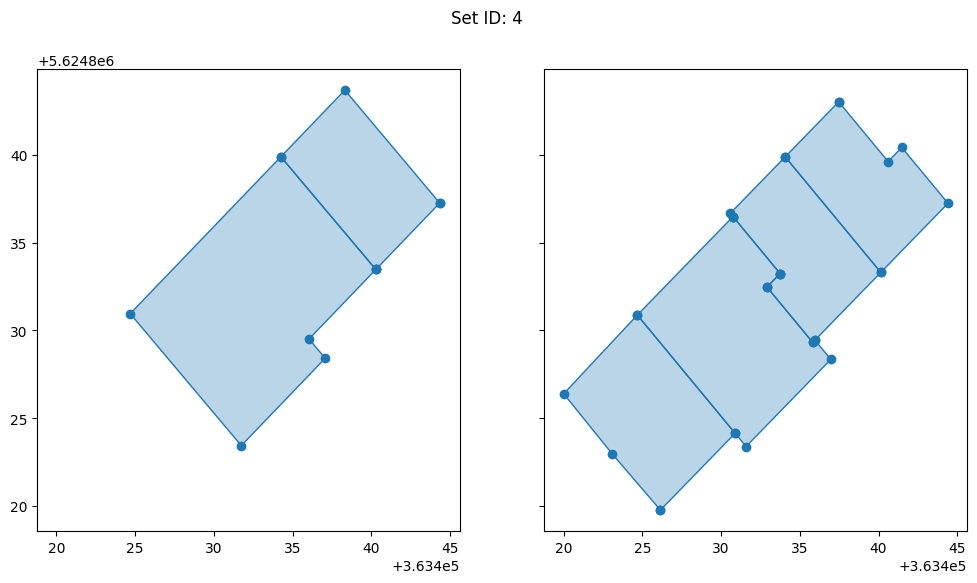

In [10]:
plot_two_polys(polys1, polys2, set_id)

## 1.3 Plot with nodes

In [11]:
# do this because there is a bug in the plot
polys1_algo1_tmp = copy.deepcopy(polys1)
polys2_algo1_tmp = copy.deepcopy(polys2)

In [12]:
G1 = algorithm_1(polys1_algo1_tmp)
G2 = algorithm_1(polys2_algo1_tmp)

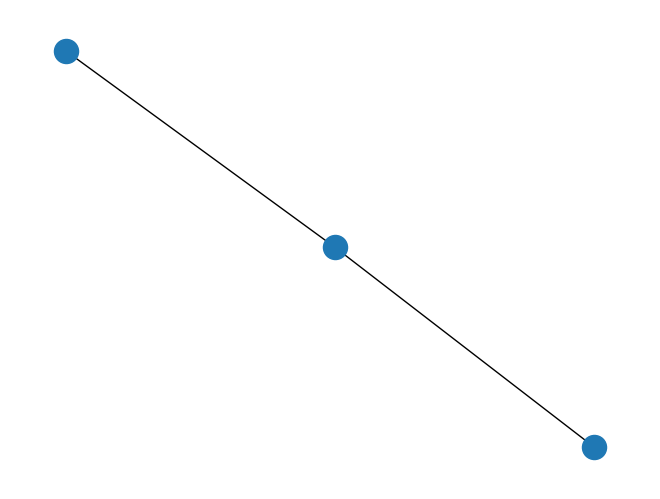

In [13]:
nx.draw(G1)

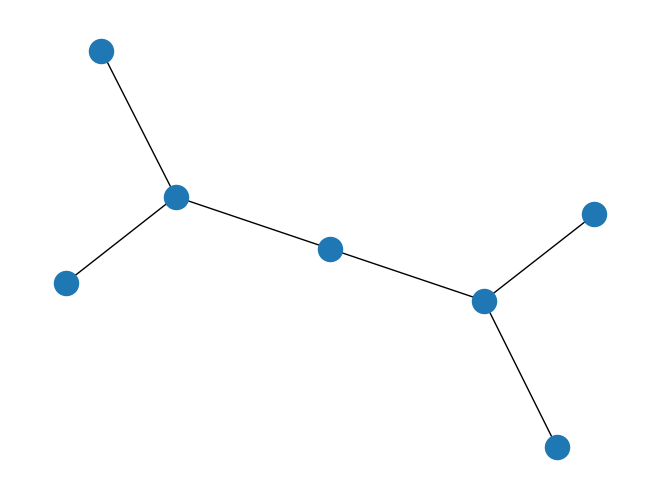

In [14]:
nx.draw(G2)

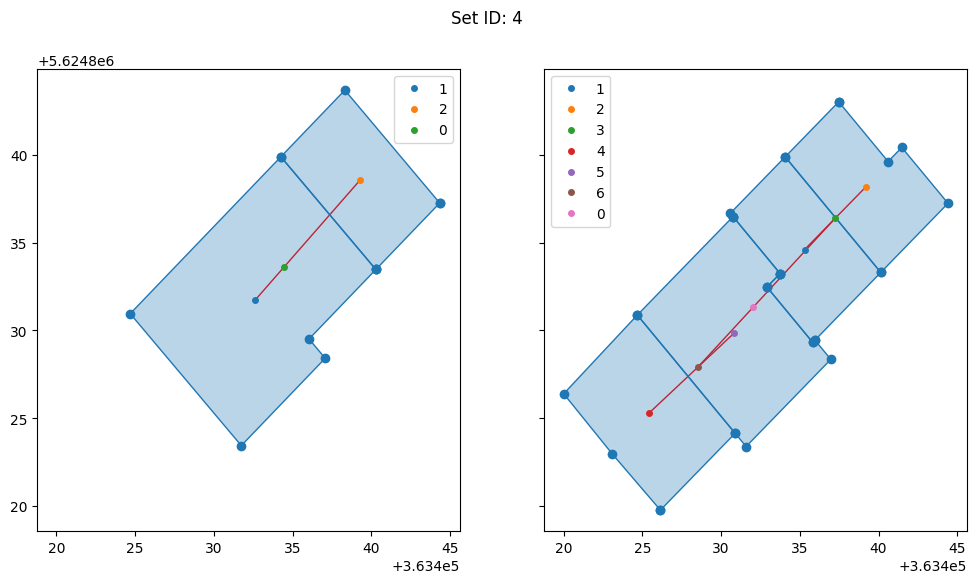

In [15]:
plot_two_polys_with_tree(polys1, polys2, G1, G2, set_id)

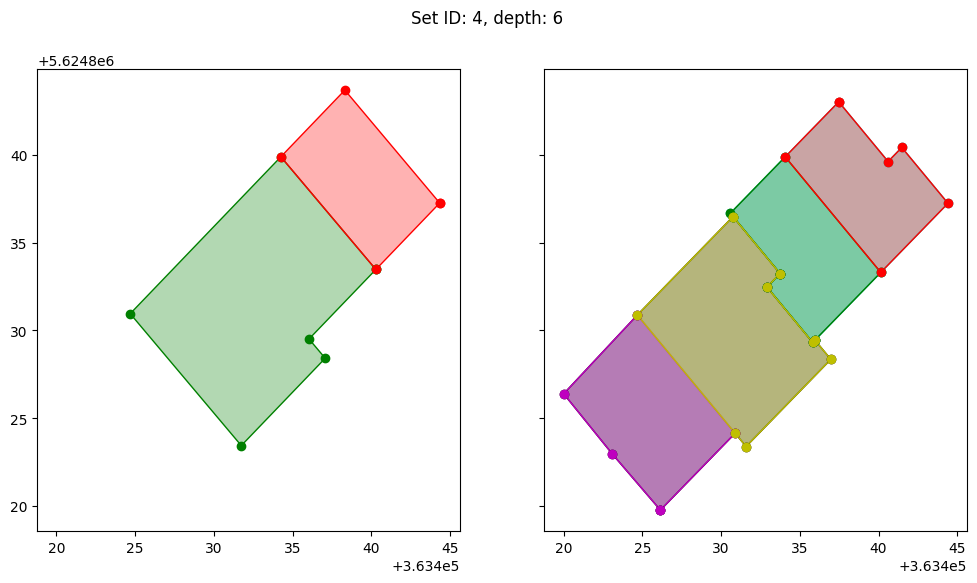

In [16]:
plot_ani(polys1, polys2, G1, G2, set_id)

## 1.3 Run on the whole datasets

In [17]:
'''
    Name,            number of sets
    data_auerberg,              796
    data_dottendorf,            871
    data_duisdorf,             2127
    data_endenich,             1060
    data_zentrum,               160
'''
file_path = "data/data_auerberg"
# file_path = "data/data_dottendorf"
# file_path = "data/data_duisdorf"
# file_path = "data/data_endenich"
# file_path = "data/data_zentrum"
reader = BinaryPolygonFileReader(file_path)

In [18]:
# Save timestamp
start = time.time()
while True:
    try:
        set_id, polys1, polys2 = reader.read_next_set()
        G1 = algorithm_1(polys1)
        G2 = algorithm_1(polys2)
    except:
        if G1 == None or G2 == None:
            print("last set id: ",set_id)
            print("Error")
            break
        else:
            print("last set id: ",set_id)
            print("Finish")
            break
        break
# Save timestamp
end = time.time()

print(end - start)

# data_auerberg   time used: 1.345
# data_dottendorf time used: 1.086
# data_duisdorf   time used: 3.714
# data_endenich   time used: 4.603
# data_zentrum    time used: 18.042

last set id:  795
Finish
1.702324390411377
